In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.spatial.distance import cdist  # Pindah ke atas!
from sklearn.utils import resample
from sklearn.metrics import silhouette_score

In [2]:
# --- FUNGSI JARAK ---
def mixed_distance_corrected(X, categorical_indices, gamma):
    """
    Menghitung pairwise distance matrix untuk data campuran,
    sesuai dengan metrik K-Prototypes.
    """
    n_samples, n_features = X.shape

    # Pisahkan numerik dan kategorikal
    numeric_indices = [i for i in range(n_features) if i not in categorical_indices]
    X_numeric = X[:, numeric_indices].astype(float)
    X_categorical = X[:, categorical_indices]

    # Hitung Euclidean untuk numerik
    if len(numeric_indices) > 0:
        # K-Prototypes menggunakan kuadrat jarak euclidean dalam cost function-nya
        dist_num = cdist(X_numeric, X_numeric, metric='sqeuclidean')
    else:
        dist_num = np.zeros((n_samples, n_samples))

    # Hitung Hamming untuk kategorikal
    if len(categorical_indices) > 0:
        dist_cat = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            # Membandingkan baris i dengan semua baris lain secara broadcast
            dist_cat[i, :] = np.sum(X_categorical[i, :] != X_categorical, axis=1)
    else:
        dist_cat = np.zeros((n_samples, n_samples))

    # Gabungkan dengan gamma SESUAI DENGAN K-PROTOTYPES
    # Cost = Jarak Numerik + gamma * Jarak Kategorikal
    return dist_num + gamma * dist_cat

def kprototypes_silhouette_score(X, labels, categorical_indices, gamma):
    """
    Menghitung silhouette score menggunakan jarak kustom yang sudah diperbaiki.
    """
    # Menggunakan sampel jika data terlalu besar (sangat direkomendasikan!)
    if X.shape[0] > 5000:
        print(f"Dataset besar ({X.shape[0]} baris), mengambil sampel 5000 titik untuk silhouette...")
        # Ambil sampel secara acak untuk efisiensi
        np.random.seed(42) # untuk reproduktifitas
        sample_indices = np.random.choice(X.shape[0], 5000, replace=False)
        X_sample = X[sample_indices]
        labels_sample = labels[sample_indices]
    else:
        X_sample = X
        labels_sample = labels

    # Hitung matriks jarak HANYA untuk sampel
    dist_matrix = mixed_distance_corrected(X_sample, categorical_indices, gamma)

    return silhouette_score(dist_matrix, labels_sample, metric='precomputed')

In [3]:
# 1. Load dataset
df = pd.read_csv('rapih_k-prototypes.csv')

In [4]:
pd.options.display.max_columns = None
df.head(10)

,Number,Priority,Category,Open Date,Closed Date,Due Date,Time Left Incl. On Hold,Item,Sub Category,Closure Category,Is SLA Violated,Is Open Date Off,Is Due Date Off,Days to Due,Open Month,Application Creation Day of Week,Application Creation Hour,Application SLA Deadline Day of Week,Application SLA Deadline Hour,Resolution Duration,Total Tickets Resolved (Wc),SLA Threshold,Average Resolution Time (Ac),SLA to Average Resolution Ratio (Rc),Application SLA Compliance Rate
0,3226221,3 - Medium,kegagalan proses,2024-01-01 01:50:00,2024-01-03 19:02:00,2024-01-02 17:30:00,0.065029,application 85,unknown,Solved,0,0,0,0.021277,1,Monday,1,Tuesday,17,0.021325,1.0,3.0,5.875479,0.002340,0.271600
1,3226225,4 - Low,event monitoring,2024-01-01 04:24:00,2024-01-03 19:02:00,2024-01-05 17:30:00,0.162572,application 344,unknown,Solved,0,0,0,0.085106,1,Monday,4,Friday,17,0.020484,1.0,5.0,4.372967,0.001620,0.271074
2,3226220,4 - Low,kegagalan proses,2024-01-01 01:39:00,2024-01-03 19:03:00,2024-01-05 17:30:00,0.162572,application 84,unknown,Solved,0,0,0,0.085106,1,Monday,1,Friday,17,0.021391,2.0,5.0,5.875479,0.002340,0.543779
3,3226263,4 - Low,event monitoring,2024-01-02 04:56:00,2024-01-04 19:00:00,2024-01-08 17:30:00,0.162572,application 91,sub kategori 62,Solved,0,0,0,0.127660,1,Tuesday,4,Monday,17,0.020298,2.0,5.0,4.372967,0.001620,0.690808
4,3226255,4 - Low,event monitoring,2024-01-01 20:13:00,2024-01-04 19:00:00,2024-01-08 17:30:00,0.162572,application 91,sub kategori 62,Solved,0,0,0,0.127660,1,Monday,20,Monday,17,0.023155,3.0,5.0,4.372967,0.001620,0.690808
5,3226250,4 - Low,event monitoring,2024-01-01 17:12:00,2024-01-04 19:00:00,2024-01-08 17:12:00,0.162331,application 91,sub kategori 62,Solved,0,0,0,0.148936,1,Monday,17,Monday,17,0.024144,4.0,5.0,4.372967,0.001620,0.690808
6,3226247,4 - Low,kegagalan proses,2024-01-01 15:56:00,2024-01-04 19:00:00,2024-01-08 15:56:00,0.161970,application 90,unknown,Solved,0,0,0,0.148936,1,Monday,15,Monday,15,0.024559,3.0,5.0,5.875479,0.002340,0.344828
7,3226239,4 - Low,event monitoring,2024-01-01 11:57:00,2024-01-04 19:00:00,2024-01-08 11:57:00,0.162151,application 89,sub kategori 18,Solved,0,0,0,0.148936,1,Monday,11,Monday,11,0.025865,5.0,5.0,4.372967,0.001620,0.643564
8,3226229,4 - Low,event monitoring,2024-01-01 08:46:00,2024-01-04 19:00:00,2024-01-08 08:46:00,0.145894,application 89,sub kategori 18,Solved,0,0,0,0.148936,1,Monday,8,Monday,8,0.026909,6.0,5.0,4.372967,0.001620,0.643564
9,3226228,3 - Medium,eod production,2024-01-01 08:20:00,2024-01-04 19:00:00,2024-01-02 17:30:00,0.032514,application 88,unknown,Solved,1,0,0,0.021277,1,Monday,8,Tuesday,17,0.027051,1.0,3.0,4.575412,0.004236,0.377778


In [5]:
kolom_untuk_dihapus = ['Closure Category', 'Sub Category']
df.drop(columns=kolom_untuk_dihapus)

,Number,Priority,Category,Open Date,Closed Date,Due Date,Time Left Incl. On Hold,Item,Is SLA Violated,Is Open Date Off,Is Due Date Off,Days to Due,Open Month,Application Creation Day of Week,Application Creation Hour,Application SLA Deadline Day of Week,Application SLA Deadline Hour,Resolution Duration,Total Tickets Resolved (Wc),SLA Threshold,Average Resolution Time (Ac),SLA to Average Resolution Ratio (Rc),Application SLA Compliance Rate
0,3226221,3 - Medium,kegagalan proses,2024-01-01 01:50:00,2024-01-03 19:02:00,2024-01-02 17:30:00,0.065029,application 85,0,0,0,0.021277,1,Monday,1,Tuesday,17,0.021325,1.0,3.0,5.875479,0.002340,0.271600
1,3226225,4 - Low,event monitoring,2024-01-01 04:24:00,2024-01-03 19:02:00,2024-01-05 17:30:00,0.162572,application 344,0,0,0,0.085106,1,Monday,4,Friday,17,0.020484,1.0,5.0,4.372967,0.001620,0.271074
2,3226220,4 - Low,kegagalan proses,2024-01-01 01:39:00,2024-01-03 19:03:00,2024-01-05 17:30:00,0.162572,application 84,0,0,0,0.085106,1,Monday,1,Friday,17,0.021391,2.0,5.0,5.875479,0.002340,0.543779
3,3226263,4 - Low,event monitoring,2024-01-02 04:56:00,2024-01-04 19:00:00,2024-01-08 17:30:00,0.162572,application 91,0,0,0,0.127660,1,Tuesday,4,Monday,17,0.020298,2.0,5.0,4.372967,0.001620,0.690808
4,3226255,4 - Low,event monitoring,2024-01-01 20:13:00,2024-01-04 19:00:00,2024-01-08 17:30:00,0.162572,application 91,0,0,0,0.127660,1,Monday,20,Monday,17,0.023155,3.0,5.0,4.372967,0.001620,0.690808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49831,3448681,4 - Low,application,2024-12-26 09:48:00,2025-01-01 19:05:00,2025-01-02 09:48:00,0.110308,application 77,1,0,0,0.148936,12,Thursday,9,Thursday,9,0.050201,7.0,5.0,5.559082,0.002826,0.289474
49832,3447611,4 - Low,application,2024-12-23 14:39:00,2025-01-01 19:05:00,2024-12-30 14:39:00,0.022218,application 96,1,0,0,0.148936,12,Monday,14,Monday,14,0.072214,7.0,5.0,5.559082,0.002826,0.463742
49833,3449018,4 - Low,application,2024-12-27 10:43:00,2025-01-01 19:05:00,2025-01-03 10:43:00,0.146797,application 83,1,0,0,0.148936,12,Friday,10,Friday,10,0.042033,7.0,5.0,5.559082,0.002826,0.364625
49834,3449430,4 - Low,application,2024-12-28 06:25:00,2025-01-01 19:05:00,2025-01-03 17:30:00,0.162572,application 88,0,1,0,0.127660,12,Saturday,6,Friday,17,0.035574,7.0,5.0,5.559082,0.002826,0.377778


In [6]:
feature_cols = ['Item', 
                'Days to Due', 'Application Creation Day of Week', 'Is Open Date Off', 'Is Due Date Off',
                 'Application SLA Deadline Day of Week',
                'Application SLA Deadline Hour', 'Average Resolution Time (Ac)', 'Application SLA Compliance Rate']

X = df[feature_cols].copy()

# --- Feature Engineering: Grouping Rare Levels ---
print("Memulai proses grouping untuk 'Item' dan 'Category'...")

# 1. Proses kolom 'Item' 
# Ambil 10 'Item' yang paling sering muncul
top_20_items = X['Item'].value_counts().nlargest(20).index

# Ganti semua item lain yang tidak termasuk top 10 menjadi 'Other_Item'
X['Item'] = X['Item'].apply(lambda x: x if x in top_20_items else 'Other_Item')

print("\nKardinalitas 'Item' setelah digabung (Top 20 + Other):")
print(X['Item'].value_counts().head(21))


# # 2. Proses kolom 'Category' 
# # Ambil 10 'Category' yang paling sering muncul
# top_20_categories = X['Category'].value_counts().nlargest(20).index

# # Ganti semua kategori lain yang tidak termasuk top 10 menjadi 'Other_Category'
# X['Category'] = X['Category'].apply(lambda x: x if x in top_20_categories else 'Other_Category')

# print("\nKardinalitas 'Category' setelah digabung (Top 20 + Other):")
# print(X['Category'].value_counts().head(11))

# print("--- Selesai Grouping ---")


# 3. Lakukan Sampling SETELAH data dimodifikasi
X_sample = X.sample(n=5000, random_state=42)  # Sesuaikan n=1000 untuk lebih cepat
print(f"\nSample shape setelah grouping: {X_sample.shape}")

Memulai proses grouping untuk 'Item' dan 'Category'...

Kardinalitas 'Item' setelah digabung (Top 20 + Other):
Item
Other_Item         17853
application 97      4870
application 300     3341
application 83      2759
application 268     2434
application 85      2338
application 167     2238
application 6       1484
application 227     1272
application 98      1262
application 101     1225
application 355     1164
application 96      1117
application 310     1083
application 73      1048
application 84       868
application 92       805
application 91       718
application 14       716
application 100      636
application 344      605
Name: count, dtype: int64

Sample shape setelah grouping: (5000, 9)


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler

# Asumsikan 'df' adalah DataFrame Anda yang sudah dimuat
# dan 'df.copy()' sudah dilakukan sebelumnya jika perlu.
# Kita akan bekerja pada X_processed
X_processed = df.copy()

# --- 1. Identifikasi Kolom ---

# Kategorikal semantik (TANPA fitur siklikal)
categorical_cols = [
    'Item', 'Priority',
    'Is Open Date Off', 'Is Due Date Off', 'Category'
    # 'Day of Week' dan 'Hour' DIHAPUS dari sini
]

# Numerik murni/kontinu (TANPA fitur siklikal)
numeric_cols = [
    'Days to Due',
    'Average Resolution Time (Ac)',
    'Application SLA Compliance Rate'
]

# Fitur siklikal yang akan di-encode
# Format: (nama_kolom, nilai_maksimum)
cyclical_cols_info = [
    ('Application Creation Day of Week', 7),
    ('Application SLA Deadline Day of Week', 7),
    ('Application Creation Hour', 24),
    ('Application SLA Deadline Hour', 24)
]

print("--- Memulai Preprocessing ---")

# --- 2. Terapkan Cyclical Encoding (JADI NUMERIK) ---
print("Menerapkan Cyclical Encoding...")
cols_to_drop_original_cyclical = []

for col, max_val in cyclical_cols_info:
    if col in X_processed.columns:
        print(f"  - Memproses {col} (max={max_val})")

        # Pastikan tipe datanya numerik sebelum operasi matematika
        X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')
        # Isi NaN jika ada (misal dari 'coerce')
        X_processed[col] = X_processed[col].fillna(0)

        # Buat kolom sin & cos
        col_sin = f'{col}_sin'
        col_cos = f'{col}_cos'
        X_processed[col_sin] = np.sin(2 * np.pi * X_processed[col] / max_val)
        X_processed[col_cos] = np.cos(2 * np.pi * X_processed[col] / max_val)

        # Tambahkan kolom baru ini ke daftar numerik
        numeric_cols.extend([col_sin, col_cos])

        # Tandai kolom asli untuk dihapus
        cols_to_drop_original_cyclical.append(col)

print("Cyclical Encoding selesai.")

# --- 3. Terapkan LabelEncoding (KATEGORIKAL) ---
print("Menerapkan LabelEncoder ke kolom kategorikal...")
for col in categorical_cols:
    if col in X_processed.columns:
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))
print("Encoding LabelEncoder selesai.")


# --- 4. Terapkan Scaling (NUMERIK, termasuk sin/cos) ---
print("Menerapkan StandardScaler ke kolom numerik...")
if numeric_cols:
    scaler = RobustScaler()
    #scaler = MinMaxScaler() 

    # Fit dan Transform kolom numerik
    X_processed[numeric_cols] = scaler.fit_transform(X_processed[numeric_cols])

print("Scaling StandardScaler selesai.")


# --- 5. Buat DataFrame Final dan Dapatkan Indeks ---

# Gabungkan daftar kolom final
final_model_cols = categorical_cols + numeric_cols

# Buat DataFrame final DENGAN URUTAN YANG PASTI
# Ini penting agar indeks kategorikalnya tidak salah
# Kita juga membuang kolom siklikal asli (misal 'Application Creation Hour')
# dan kolom lain yang tidak ada di daftar 'final_model_cols'
X_processed_final = X_processed[final_model_cols]

# Dapatkan indeks kategorikal berdasarkan DataFrame final
# Karena kita menempatkan semua 'categorical_cols' di awal,
# indeksnya akan berurutan dari 0
categorical_indices = [X_processed_final.columns.get_loc(c) for c in categorical_cols if c in X_processed_final.columns]

print("\n--- Preprocessing Selesai ---")
print(f"Kolom kategorikal akhir: {categorical_cols}")
print(f"Total kolom kategorikal: {len(categorical_cols)}")
print(f"Kolom numerik akhir (termasuk sin/cos): {numeric_cols}")
print(f"Total kolom numerik: {len(numeric_cols)}")
print(f"Total fitur untuk model: {len(X_processed_final.columns)}")
print(f"\nIndeks kategorikal untuk model: {categorical_indices}")

# Data yang SIAP dimasukkan ke K-Prototypes adalah:
#  data_matrix = X_processed_final.values

--- Memulai Preprocessing ---
Menerapkan Cyclical Encoding...
  - Memproses Application Creation Day of Week (max=7)
  - Memproses Application SLA Deadline Day of Week (max=7)
  - Memproses Application Creation Hour (max=24)
  - Memproses Application SLA Deadline Hour (max=24)
Cyclical Encoding selesai.
Menerapkan LabelEncoder ke kolom kategorikal...
Encoding LabelEncoder selesai.
Menerapkan StandardScaler ke kolom numerik...
Scaling StandardScaler selesai.

--- Preprocessing Selesai ---
Kolom kategorikal akhir: ['Item', 'Priority', 'Is Open Date Off', 'Is Due Date Off', 'Category']
Total kolom kategorikal: 5
Kolom numerik akhir (termasuk sin/cos): ['Days to Due', 'Average Resolution Time (Ac)', 'Application SLA Compliance Rate', 'Application Creation Day of Week_sin', 'Application Creation Day of Week_cos', 'Application SLA Deadline Day of Week_sin', 'Application SLA Deadline Day of Week_cos', 'Application Creation Hour_sin', 'Application Creation Hour_cos', 'Application SLA Deadline 

In [8]:
# Simpan data hasil pra-pemrosesan ke CSV
X_processed_final.to_csv('data_preprocessed_ready_for_model.csv', index=False)

print("File 'data_preprocessed_ready_for_model.csv' berhasil disimpan.")

File 'data_preprocessed_ready_for_model.csv' berhasil disimpan.


In [9]:
sample_size_fraction = 0.25
X_sample_for_tuning = resample(X_processed_final,
                              n_samples=int(len(X_processed_final) * sample_size_fraction),
                              random_state=42)

# print(f"Data asli: {len(X_processed_final)} baris. Data sampel: {len(X_sample_for_elbow)} baris.")
X_sample_matrix = X_sample_for_tuning.values

#Gunakan X_sample_matrix dan k=3 
gamma_range = [0.1, 0.5, 1, 5, 10, 20, 50] 
scores = []

for g in gamma_range:
    print(f"Menguji gamma={g}...")
    kproto_gamma = KPrototypes(n_clusters=3,
                              init='Cao',
                              n_init=5,
                              verbose=0,
                              random_state=42,
                              n_jobs=-1,
                              gamma=g) # <-- Atur gamma secara manual
    
    clusters_gamma = kproto_gamma.fit_predict(X_sample_matrix, categorical=categorical_indices)
    
    score = kprototypes_silhouette_score(
        X_sample_matrix,
        clusters_gamma,
        categorical_indices,
        g # Gunakan gamma yang Anda set
    )
    scores.append(score)
    print(f"Score untuk gamma={g}: {score:.4f}")

# Temukan gamma terbaik
best_gamma = gamma_range[np.argmax(scores)]
print(f"\nGamma terbaik (dari sampel): {best_gamma}")

Menguji gamma=0.1...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Score untuk gamma=0.1: 0.5613
Menguji gamma=0.5...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Score untuk gamma=0.5: 0.5383
Menguji gamma=1...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Score untuk gamma=1: 0.5330
Menguji gamma=5...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Score untuk gamma=5: 0.2253
Menguji gamma=10...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Score untuk gamma=10: 0.2287
Menguji gamma=20...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Score untuk gamma=20: 0.2261
Menguji gamma=50...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Score untuk gamma=50: 0.2518

Gamma terbaik (dari sampel): 0.1


Menguji k=2 untuk silhouette...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Selesai k=2, Score=0.5400
Menguji k=3 untuk silhouette...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Selesai k=3, Score=0.5528
Menguji k=4 untuk silhouette...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Selesai k=4, Score=0.4946
Menguji k=5 untuk silhouette...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Selesai k=5, Score=0.4479
Menguji k=6 untuk silhouette...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Selesai k=6, Score=0.4389
Menguji k=7 untuk silhouette...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Selesai k=7, Score=0.3495
Menguji k=8 untuk silhouette...
Dataset besar (12459 baris), mengambil sampel 5000 titik untuk silhouette...
Selesai k=8, Score=0.3751
Menguji k=9 untuk silhouette...
Dataset besar (12459 ba

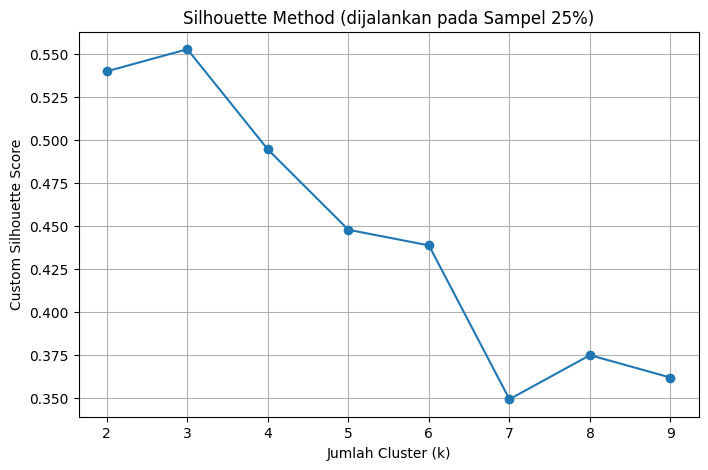

In [10]:
K_max = 9
K_range = range(2, K_max + 1)
silhouette_scores = []
# Dapatkan gamma "rata-rata" dari sampel, atau gunakan gamma dari model k=3 
estimated_gamma = best_gamma
for k_sil in K_range:
    print(f"Menguji k={k_sil} untuk silhouette...")
    kproto_temp = KPrototypes(n_clusters=k_sil,
                              init='Cao', 
                              n_init=5,  # Tidak perlu tinggi, ini hanya tes
                              verbose=0, 
                              random_state=42, 
                              n_jobs=-1)
    
    clusters_temp = kproto_temp.fit_predict(X_sample_matrix, categorical=categorical_indices)

    current_gamma = kproto_temp.gamma
    score = kprototypes_silhouette_score(
        X_sample_matrix,  # Gunakan sampel
        clusters_temp,       # Label dari sampel
        categorical_indices,
        current_gamma        # Gunakan gamma yang relevan
    )
    
    silhouette_scores.append(score)
    print(f"Selesai k={k_sil}, Score={score:.4f}")

# Plot hasil
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Method (dijalankan pada Sampel 25%)')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Custom Silhouette Score')
plt.xticks(K_range)
plt.grid(True)
plt.savefig('kprototypes_silhouette_plot_SAMPLE.png')

# Tampilkan k terbaik
best_k = K_range[np.argmax(silhouette_scores)]
print(f"K terbaik berdasarkan Silhouette: {best_k}")

In [11]:
optimal_k = best_k # <--- GANTI  berdasarkan "siku" pada plot 
print(f"\nOptimal k yang dipilih (dari sampel): {optimal_k}")


# --- LANGKAH 4: Latih Model FINAL pada DATA LENGKAP ---
print(f"\nMelatih model FINAL pada DATA LENGKAP (100%) dengan k={optimal_k}...")

# Dapatkan data matriks LENGKAP
data_matrix_full = X_processed_final.values

final_kproto = KPrototypes(n_clusters=optimal_k,
                           init='Cao',
                           n_init=151,         # Gunakan n_init TINGGI untuk hasil final
                           verbose=1,         # Set ke 1 untuk melihat progress
                           random_state=42,
                           gamma=best_gamma,
                           n_jobs=-1)

# Latih pada data_matrix_FULL
final_clusters = final_kproto.fit_predict(data_matrix_full, categorical=categorical_indices)

print("--- Model Final Selesai Dilatih ---")
# 'final_clusters' adalah hasil akhir Anda yang representatif


Optimal k yang dipilih (dari sampel): 3

Melatih model FINAL pada DATA LENGKAP (100%) dengan k=3...
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 60
--- Model Final Selesai Dilatih ---


In [12]:
custom_score = kprototypes_silhouette_score(
    data_matrix_full,       # Data lengkap (fungsi ini akan mengambil sampel secara internal)
    final_clusters,         # Label lengkap (fungsi ini akan mengambil sampel secara internal)
    categorical_indices,    # Indeks kategorikal Anda
    final_kproto.gamma     # Gamma yang dipelajari dari model
)

print(f"\nCustom K-Prototypes Silhouette Score: {custom_score:.4f}")

# --- 6. Tampilkan Distribusi Cluster (Ini sudah benar) ---
print("\nDistribusi Cluster (dari Data Penuh):")
print(pd.Series(final_clusters).value_counts().sort_index())

Dataset besar (49836 baris), mengambil sampel 5000 titik untuk silhouette...

Custom K-Prototypes Silhouette Score: 0.5871

Distribusi Cluster (dari Data Penuh):
0    35955
1     9295
2     4586
Name: count, dtype: int64


In [13]:
print("\n--- 7. Analisis Centroid (Memaknai Cluster) ---")

# 1. Muat kembali data ASLI (human-readable)
# Ini penting agar kita bisa membaca nilainya (bukan nilai scaled/encoded)
try:
    df_analysis = pd.read_csv('rapih_k-prototypes.csv')
    print("Berhasil memuat 'rapih_k-prototypes.csv' untuk analisis.")
except Exception as e:
    print(f"Gagal memuat 'rapih_k-prototypes.csv': {e}")
    # Jika gagal, kita tidak bisa lanjut
    exit()

# 2. Sanity Check: Pastikan panjang data asli cocok dengan label cluster
# Ini HANYA akan berfungsi jika Anda tidak memfilter baris apapun
# selama preprocessing
if len(df_analysis) != len(final_clusters):
    print(f"Error Kritis: Panjang data asli ({len(df_analysis)}) tidak cocok "
          f"dengan label cluster ({len(final_clusters)}).")
    print("Analisis tidak bisa dilanjutkan.")
else:
    # 3. Tambahkan label cluster ke data asli
    df_analysis['Cluster'] = final_clusters
    print(f"Berhasil menambahkan {len(final_clusters)} label cluster ke data asli.")

    # 4. Tentukan kolom ASLI yang ingin kita analisis
    # (Ini adalah kolom SEBELUM di-scale atau di-encode)

    # Kolom numerik asli yang menarik
    numeric_cols_original = [
        'Days to Due',
        'Average Resolution Time (Ac)',
        'Application SLA Compliance Rate',
        'Resolution Duration',
        'SLA Threshold',
        'Is SLA Violated' # Meskipun biner, melihat meannya (sebagai %) itu berguna
    ]

    # Kolom kategorikal asli yang menarik
    categorical_cols_original = [
        'Priority',
        'Item',
        'Application Creation Day of Week',
        'Application Creation Hour',
        'Is Open Date Off',
        'Is Due Date Off',
        'Open Month',
        'Application SLA Deadline Hour',
        'Application SLA Deadline Day of Week'
    ]

    # Filter agar hanya kolom yang ada di DataFrame
    numeric_cols_to_analyze = [col for col in numeric_cols_original if col in df_analysis.columns]
    categorical_cols_to_analyze = [col for col in categorical_cols_original if col in df_analysis.columns]

    # --- 5. Analisis Fitur Numerik ---
    print("\n--- Ringkasan Fitur Numerik per Cluster (Data Asli) ---")
    # Kita gunakan 'mean', 'median', dan 'std' untuk melihat tendensi sentral dan sebarannya
    numeric_summary = df_analysis.groupby('Cluster')[numeric_cols_to_analyze].agg(['mean', 'median', 'std'])

    # Tampilkan hasilnya
    print(numeric_summary)

    # Simpan ke file agar mudah dibaca
    numeric_summary.to_csv("cluster_summary_numeric.csv")
    print("\nRingkasan numerik disimpan ke 'cluster_summary_numeric.csv'")

    # --- 6. Analisis Fitur Kategorikal ---
    print("\n--- Ringkasan Fitur Kategorikal per Cluster (Data Asli) ---")
    # Kita gunakan 'mode' (nilai paling sering muncul)
    # .mode().tolist() adalah cara aman untuk menampilkannya
    categorical_summary = df_analysis.groupby('Cluster')[categorical_cols_to_analyze].agg(lambda x: x.mode().tolist())

    # Tampilkan hasilnya
    print(categorical_summary)


--- 7. Analisis Centroid (Memaknai Cluster) ---
Berhasil memuat 'rapih_k-prototypes.csv' untuk analisis.
Berhasil menambahkan 49836 label cluster ke data asli.

--- Ringkasan Fitur Numerik per Cluster (Data Asli) ---
        Days to Due                     Average Resolution Time (Ac)  \
               mean    median       std                         mean   
Cluster                                                                
0          0.144516  0.148936  0.013662                     5.486937   
1          0.134678  0.148936  0.030414                     6.170171   
2          0.099215  0.127660  0.040929                     5.527408   

                            Application SLA Compliance Rate            \
           median       std                            mean    median   
Cluster                                                                 
0        5.255530  0.491369                        0.399477  0.383851   
1        5.875479  0.954734                        0.2164

In [14]:
# --- KODE ANALISIS BARU (PERSENTASE & RANGE) ---
# Jalankan cell ini SETELAH Cell 13 selesai

def analisis_cluster_detail(df, col_cluster, col_numerikal, col_kategorikal):
    unique_clusters = sorted(df[col_cluster].unique())
    
    print(f"\n=== ANALISIS DETAIL CLUSTER (Sesuai Masukan Dosen) ===\n")
    print(f"Total Data: {len(df)} baris")
    
    for cluster_id in unique_clusters:
        df_cluster = df[df[col_cluster] == cluster_id]
        n_data = len(df_cluster)
        proporsi = n_data / len(df) * 100
        
        print(f"\n{'='*60}")
        print(f"CLUSTER {cluster_id} | Jumlah: {n_data} ({proporsi:.1f}%)")
        print(f"{'='*60}")
        
        # 1. Analisis Numerikal (Range & Mean)
        print(f"\n[Fitur Numerikal - Range & Rata-rata]")
        print(f"{'-'*60}")
        for col in col_numerikal:
            stats = df_cluster[col].describe()
            _min = stats['min']
            _max = stats['max']
            _mean = stats['mean']
            print(f"• {col:<35} : Range {_min:.2f} - {_max:.2f} (Avg: {_mean:.2f})")
        
        # 2. Analisis Kategorikal (Persentase Komposisi)
        print(f"\n[Fitur Kategorikal - Dominansi & Persentase]")
        print(f"{'-'*60}")
        for col in col_kategorikal:
            # Hitung persentase
            counts = df_cluster[col].value_counts(normalize=True) * 100
            top_3 = counts.head(3)
            
            # Format string output
            detail_str = ", ".join([f"{idx} ({val:.1f}%)" for idx, val in top_3.items()])
            print(f"• {col:<35} : {detail_str}")

# PANGGIL FUNGSI MENGGUNAKAN VARIABEL DARI CELL 13
# df_analysis = dataframe yang sudah ada label clusternya (dari Cell 13)
# 'Cluster' = nama kolom label (dari Cell 13)
# numeric_cols_to_analyze = list kolom numerik (dari Cell 13)
# categorical_cols_to_analyze = list kolom kategorikal (dari Cell 13)

analisis_cluster_detail(
    df_analysis, 
    'Cluster', 
    numeric_cols_to_analyze, 
    categorical_cols_to_analyze
)


=== ANALISIS DETAIL CLUSTER (Sesuai Masukan Dosen) ===

Total Data: 49836 baris

CLUSTER 0 | Jumlah: 35955 (72.1%)

[Fitur Numerikal - Range & Rata-rata]
------------------------------------------------------------
• Days to Due                         : Range 0.00 - 0.15 (Avg: 0.14)
• Average Resolution Time (Ac)        : Range 3.13 - 10.78 (Avg: 5.49)
• Application SLA Compliance Rate     : Range 0.25 - 1.00 (Avg: 0.40)
• Resolution Duration                 : Range 0.00 - 1.00 (Avg: 0.04)
• SLA Threshold                       : Range 0.08 - 5.00 (Avg: 4.99)
• Is SLA Violated                     : Range 0.00 - 1.00 (Avg: 0.61)

[Fitur Kategorikal - Dominansi & Persentase]
------------------------------------------------------------
• Priority                            : 4 - Low (99.5%), 3 - Medium (0.5%), 1 - Critical (0.0%)
• Item                                : application 97 (13.0%), application 300 (8.5%), application 83 (7.5%)
• Application Creation Day of Week    : Monday (24

c:\Users\stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Library 'umap-learn' ditemukan — UMAP akan digunakan (lebih cepat dari t-SNE).
Library 'prince' ditemukan untuk MCA.
Data numerik: 11 fitur
Data kategorikal: 5 fitur

▶ Menjalankan PCA pada fitur numerik...
✅ PCA selesai.

▶ Menjalankan MCA pada fitur kategorikal...
✅ MCA selesai.

▶ Menggabungkan hasil PCA dan MCA...
✅ Gabungan berhasil: 4 dimensi (2 PCA + 2 MCA)

▶ Menormalkan gabungan komponen PCA dan MCA...
✅ Normalisasi selesai.

▶ Menjalankan UMAP untuk reduksi ke 2D (lebih cepat dari t-SNE)...


c:\Users\stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\stefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. 

✅ UMAP selesai.

▶ Membuat visualisasi cluster...


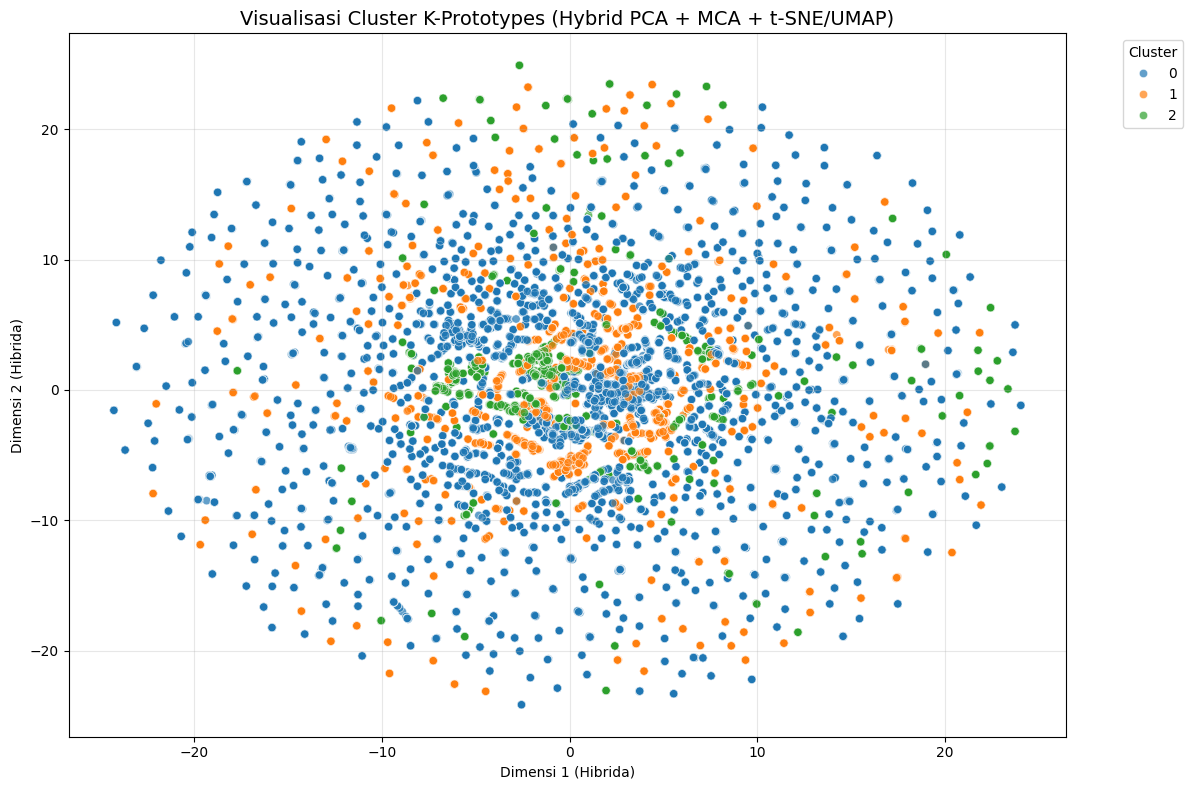


✅ Visualisasi selesai dan disimpan sebagai 'cluster_visualization_hybrid_optimized.png'


In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, StandardScaler

try:
    import umap
    use_umap = True
    print("Library 'umap-learn' ditemukan — UMAP akan digunakan (lebih cepat dari t-SNE).")
except ImportError:
    use_umap = False
    print("Library 'umap-learn' tidak ditemukan — akan menggunakan t-SNE sebagai gantinya.")

# MCA library
try:
    import prince
    print("Library 'prince' ditemukan untuk MCA.")
except ImportError:
    raise ImportError("Library 'prince' belum diinstal. Jalankan: pip install prince")

# --- 2. Validasi Variabel Input ---
try:
    X_numeric_scaled = X_processed_final[numeric_cols]
    X_categorical_le = X_processed_final[categorical_cols]
except NameError as e:
    raise NameError(f"Variabel yang dibutuhkan tidak ditemukan: {e}")

print(f"Data numerik: {X_numeric_scaled.shape[1]} fitur")
print(f"Data kategorikal: {X_categorical_le.shape[1]} fitur")

# --- 3. PCA untuk Fitur Numerik ---
print("\n▶ Menjalankan PCA pada fitur numerik...")
pca = PCA(n_components=2, random_state=42)
X_pca_components = pca.fit_transform(X_numeric_scaled)
print("✅ PCA selesai.")

# --- 4. MCA untuk Fitur Kategorikal ---
print("\n▶ Menjalankan MCA pada fitur kategorikal...")

# One-Hot Encode agar data kategorikal bisa diproses MCA
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_categorical_ohe_array = ohe.fit_transform(X_categorical_le)

# Ubah ke DataFrame (dibutuhkan oleh prince)
ohe_feature_names = ohe.get_feature_names_out(X_categorical_le.columns.to_list())
X_categorical_ohe_df = pd.DataFrame(X_categorical_ohe_array, columns=ohe_feature_names)

# Jalankan MCA
mca = prince.MCA(n_components=2, random_state=42)
X_mca_components = mca.fit(X_categorical_ohe_df).transform(X_categorical_ohe_df).values
print("✅ MCA selesai.")

# --- 5. Gabungkan Komponen PCA + MCA ---
print("\n▶ Menggabungkan hasil PCA dan MCA...")
X_combined_4D = np.hstack((X_pca_components, X_mca_components))
print(f"✅ Gabungan berhasil: {X_combined_4D.shape[1]} dimensi (2 PCA + 2 MCA)")

# --- ⚙️ 6. Normalisasi Skala (PENTING) ---
# Ini memastikan PCA dan MCA punya kontribusi seimbang saat divisualisasi
print("\n▶ Menormalkan gabungan komponen PCA dan MCA...")
scaler = StandardScaler()
X_combined_4D_scaled = scaler.fit_transform(X_combined_4D)
print("✅ Normalisasi selesai.")

# --- 7. Reduksi ke 2D untuk Visualisasi (t-SNE atau UMAP) ---
if use_umap:
    print("\n▶ Menjalankan UMAP untuk reduksi ke 2D (lebih cepat dari t-SNE)...")
    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_visual_2D = umap_reducer.fit_transform(X_combined_4D_scaled)
    print("✅ UMAP selesai.")
else:
    print("\n▶ Menjalankan t-SNE (ini mungkin butuh waktu)...")
    n_samples = X_combined_4D_scaled.shape[0]
    perplexity_val = min(30.0, max(5.0, n_samples - 1.0))
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, n_iter=1000)
    X_visual_2D = tsne.fit_transform(X_combined_4D_scaled)
    print("✅ t-SNE selesai.")

# --- 8. Plot Visualisasi Cluster ---
print("\n▶ Membuat visualisasi cluster...")

df_plot = pd.DataFrame(X_visual_2D, columns=['Dim 1', 'Dim 2'])
df_plot['Cluster'] = final_clusters
df_plot['Cluster'] = df_plot['Cluster'].astype('category')

# Warna cluster konsisten
unique_clusters = sorted(df_plot['Cluster'].unique())
palette = sns.color_palette('tab10', n_colors=len(unique_clusters))

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Dim 1', y='Dim 2',
    hue='Cluster',
    data=df_plot,
    palette=palette,
    hue_order=unique_clusters,
    alpha=0.7
)
plt.title('Visualisasi Cluster K-Prototypes (Hybrid PCA + MCA + t-SNE/UMAP)', fontsize=14)
plt.xlabel('Dimensi 1 (Hibrida)')
plt.ylabel('Dimensi 2 (Hibrida)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Simpan hasil
plt.tight_layout()
plt.savefig('cluster_visualization_hybrid_optimized.png', dpi=300)
plt.show()

print("\n✅ Visualisasi selesai dan disimpan sebagai 'cluster_visualization_hybrid_optimized.png'")


--- 9. Membuat Plot Visualisasi Terpisah ---
Membuat plot PCA (Numerik)...
Plot PCA disimpan sebagai 'cluster_visualization_PCA_only.png'
Membuat plot MCA (Kategorikal)...
Plot MCA disimpan sebagai 'cluster_visualization_MCA_only.png'

✅ Dua plot terpisah telah disimpan.


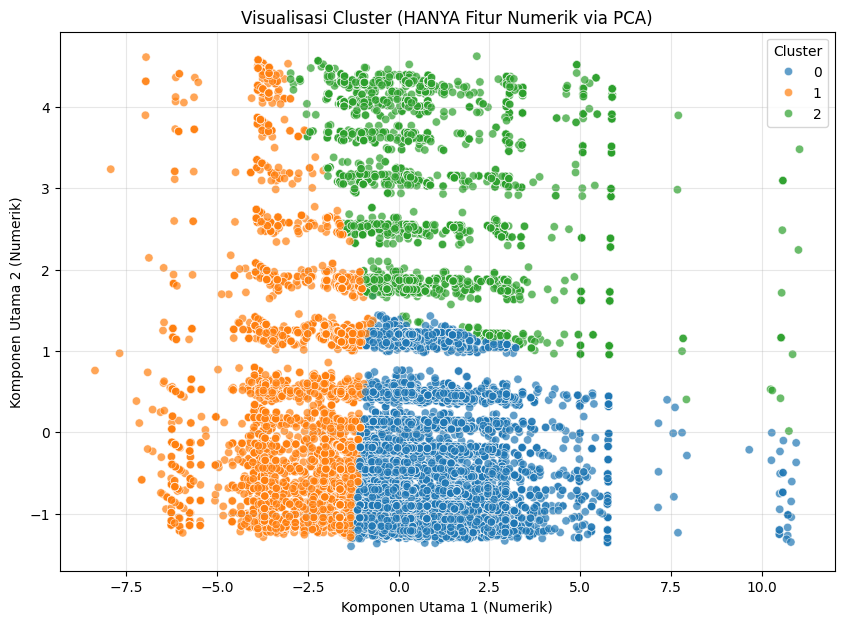

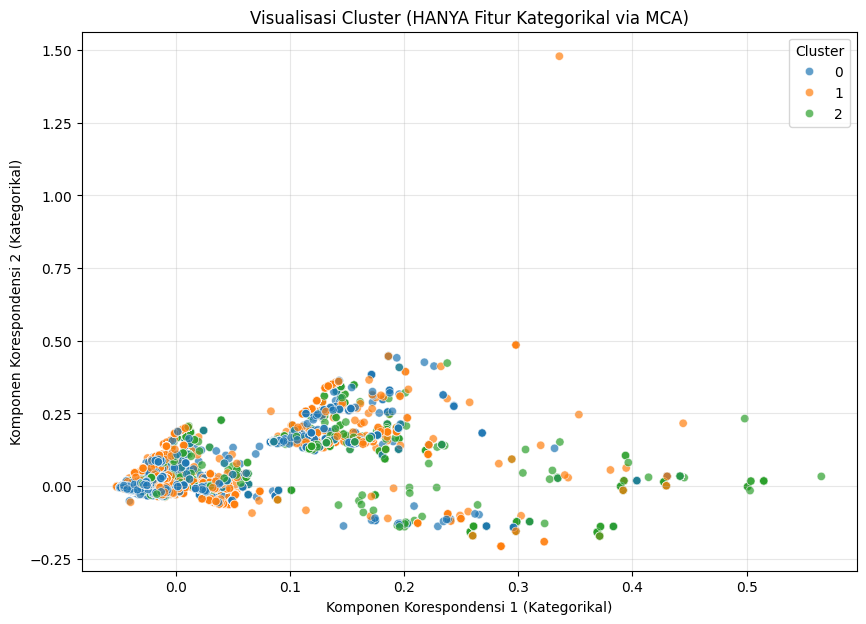

In [16]:
# --- 9. Visualisasi Terpisah (PCA vs MCA) ---

print("\n--- 9. Membuat Plot Visualisasi Terpisah ---")

# Kita asumsikan variabel-variabel ini sudah ada dari langkah sebelumnya:
# X_pca_components : Hasil PCA (N baris, 2 kolom)
# X_mca_components : Hasil MCA (N baris, 2 kolom)
# final_clusters   : Label cluster (array numpy)
# optimal_k        : Jumlah k optimal (misal: 3)

try:
    # --- Plot 1: PCA Saja (Numerik) ---
    print("Membuat plot PCA (Numerik)...")
    df_plot_pca = pd.DataFrame(X_pca_components, columns=['PC 1', 'PC 2'])
    df_plot_pca['Cluster'] = final_clusters
    df_plot_pca['Cluster'] = df_plot_pca['Cluster'].astype('category')

    unique_clusters = sorted(df_plot_pca['Cluster'].unique())
    palette = sns.color_palette('tab10', n_colors=len(unique_clusters))

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x='PC 1',
        y='PC 2',
        hue='Cluster',
        palette=palette,
        hue_order=unique_clusters,
        data=df_plot_pca,
        alpha=0.7
    )
    plt.title('Visualisasi Cluster (HANYA Fitur Numerik via PCA)')
    plt.xlabel('Komponen Utama 1 (Numerik)')
    plt.ylabel('Komponen Utama 2 (Numerik)')
    plt.legend(title='Cluster')
    plt.grid(True, alpha=0.3)

    plt.savefig('cluster_visualization_PCA_only.png')
    print("Plot PCA disimpan sebagai 'cluster_visualization_PCA_only.png'")

    # --- Plot 2: MCA Saja (Kategorikal) ---
    print("Membuat plot MCA (Kategorikal)...")
    df_plot_mca = pd.DataFrame(X_mca_components, columns=['MCA 1', 'MCA 2'])
    df_plot_mca['Cluster'] = final_clusters
    df_plot_mca['Cluster'] = df_plot_mca['Cluster'].astype('category')

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x='MCA 1',
        y='MCA 2',
        hue='Cluster',
        palette=palette,
        hue_order=unique_clusters,
        data=df_plot_mca,
        alpha=0.7
    )
    plt.title('Visualisasi Cluster (HANYA Fitur Kategorikal via MCA)')
    plt.xlabel('Komponen Korespondensi 1 (Kategorikal)')
    plt.ylabel('Komponen Korespondensi 2 (Kategorikal)')
    plt.legend(title='Cluster')
    plt.grid(True, alpha=0.3)

    plt.savefig('cluster_visualization_MCA_only.png')
    print("Plot MCA disimpan sebagai 'cluster_visualization_MCA_only.png'")

    print("\n✅ Dua plot terpisah telah disimpan.")

except NameError as e:
    print(f"\nError: Variabel yang dibutuhkan tidak ditemukan: {e}")
    print("Pastikan Anda telah menjalankan kode visualisasi hibrida (Langkah 8) terlebih dahulu.")
except Exception as e:
    print(f"\nTerjadi error saat visualisasi terpisah: {e}")

In [17]:
# ============================================
# BAGIAN 7: EKSTRAK HASIL CLUSTERING KE JSON (DIPERBAIKI)
# ============================================
import json
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score # Pastikan ini diimpor jika ingin hitung lagi
print("\nMemulai ekstraksi hasil clustering ke format JSON...")
# --- Variabel yang dibutuhkan dari langkah-langkah sebelumnya ---
# (Diasumsikan variabel berikut sudah terdefinisi: optimal_k, best_gamma, final_clusters, X_visual_2D, df_analysis, dll.)
try:
    optimal_k = best_k # Hasil K terbaik dari langkah 20
    gamma_final = best_gamma # Hasil Gamma terbaik dari langkah 19
    cluster_labels = final_clusters
    final_visual_coords = X_visual_2D
    X_with_clusters = df_analysis.copy()
    numerical_cols_original_names = numeric_cols_to_analyze
    categorical_cols_original_names = categorical_cols_to_analyze
    final_silhouette_score = custom_score
except NameError as e:
    print(f"Error: Variabel yang dibutuhkan tidak ditemukan - {e}")
    exit()
# 1. Buat Ringkasan per Cluster (Gunakan Data Asli 'X_with_clusters' untuk Interpretasi)

print("Membuat ringkasan per cluster...")

summary = {}
if 'Cluster' in X_with_clusters.columns:
    for cluster_id in range(optimal_k):
        mask = (X_with_clusters['Cluster'] == cluster_id)
        cluster_data = X_with_clusters[mask]
        # Rata-rata fitur numerik (dari data asli)
        mean_num = {}
        if numerical_cols_original_names:
            if not cluster_data.empty:
                # Mengonversi mean ke dict akan menghasilkan tipe np.float64 yang perlu diubah
                mean_num = cluster_data[numerical_cols_original_names].mean().round(4).to_dict()
            else:
                mean_num = {col: 'NaN' for col in numerical_cols_original_names}
        # Modus fitur kategorikal (dari data asli)
        mode_cat = {}
        if categorical_cols_original_names:
            for col in categorical_cols_original_names:
                if not cluster_data.empty and col in cluster_data:
                    mode_val = cluster_data[col].mode()
                    # mode_val.iloc[0] bisa berupa tipe np.int64 atau np.object (string)
                    mode_cat[col] = mode_val.iloc[0] if not mode_val.empty else 'Unknown'
                else:
                    mode_cat[col] = 'Unknown'
        summary[cluster_id] = {
            'mean_numerical': mean_num,
            'mode_categorical': mode_cat,
            # Konversi np.int64 (dari mask.sum()) secara eksplisit
            'size': int(mask.sum())
        }
else:
    print("Error: Kolom 'Cluster' tidak ditemukan di X_with_clusters. Ringkasan tidak dapat dibuat.")
    summary = {"error": "Missing Cluster column"}
# 2. Gabungkan Semua Hasil ke Dictionary
print("Menggabungkan hasil ke dictionary...")
cluster_results = {
    'num_clusters': optimal_k,
    'best_gamma': gamma_final,
    'final_silhouette_score': final_silhouette_score,
    # Menggunakan koordinat 2D (UMAP/t-SNE) untuk visualisasi hibrida di web
    'visual_coords_2d': final_visual_coords.tolist() if isinstance(final_visual_coords, np.ndarray) else final_visual_coords,
    'pca_coords': X_pca_components.tolist(),          # (PCA)
    'mca_coords': X_mca_components.tolist(),          # (MCA)
    'cluster_labels': cluster_labels.tolist() if isinstance(cluster_labels, np.ndarray) else cluster_labels,
    'summary_per_cluster': summary,
    # Nama kolom untuk referensi di frontend
    'numerical_columns_summary': numerical_cols_original_names,
    'categorical_columns_summary': categorical_cols_original_names,
}

# 3. Simpan ke File JSON (PENTING: Definisikan fungsi encoder yang benar)

file_path = 'cluster_results.json'
print(f"Menyimpan hasil lengkap ke '{file_path}'...")
def numpy_encoder(obj):
    if isinstance(obj, np.generic): return obj.item()
    if isinstance(obj, float) and np.isnan(obj): return 'NaN'
    raise TypeError(f"Object of type {type(obj).__name__} is not JSON serializable")
with open(file_path, 'w') as f:
    json.dump(cluster_results, f, indent=4, default=numpy_encoder)
print(f"Hasil berhasil disimpan! Pindahkan '{file_path}' ke folder static Django Anda.")


Memulai ekstraksi hasil clustering ke format JSON...
Membuat ringkasan per cluster...
Menggabungkan hasil ke dictionary...
Menyimpan hasil lengkap ke 'cluster_results.json'...
Hasil berhasil disimpan! Pindahkan 'cluster_results.json' ke folder static Django Anda.
